# Speech recognition

The purpose of this assignment is to build a speech classifier in tensorflow to classify 30 different words. The data is downloaded from http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz. We will use our classifier to classify 30 words. The data consists of 65,000 one-second long words produced by thousands of different people. The words to sort are given below
['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [50]:
from scipy.io import wavfile
import os
import glob
import numpy as np
from scipy import fft #discrete fourier transform
from scipy import signal
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
import keras
from tensorflow.contrib.rnn import BasicLSTMCell, DropoutWrapper, MultiRNNCell, GRUCell
import sys

In [3]:
# loop through all folders and get sounds
path="...//audio"
# list of all the sounds
sounds = [sound for sound in os.listdir(path) if '_' not in sound and '.' not in sound and sound.lower()==sound]

expected_samples = 16000

In [4]:
sounds

['bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero']

So the first thing we need to do is sample the audio wave to represent it as a wave form. We will be sampling the audio waves at 16 k hz, this means we take 16,000 samples per second. Since each clip is 1 second long we want to create an array 16,000 samples for each sound clip. We will get the amplitude values against time for each sound file. We will also create a corresponding y variable which stores the integer sound label.

In [5]:
# get amplitudes using wavfile
audiodat = []
y = []

# loop through sounds
for i, sound in enumerate(sounds):    
    for wav_file in glob.glob("{}/{}/*.wav".format(path,sound)):
        wav = wavfile.read(wav_file)[1]
        audiodat.append(wav)
        y.append(i)
            


Next we will pad sounds that have less than 16000 samples with zeros so the data has the same shape. 

In [14]:
# if files have less than 1600 samples need pad them with zeros

for j in np.where(np.array(list(map(len, audiodat))) != 16000)[0]:
    audiodat[j] = np.append(np.zeros(expected_samples - len(audiodat[j]),dtype=np.int16), audiodat[j])

audiodat = np.vstack(audiodat).astype(np.float16)
y = np.array(y)

# make y one hot encoded
Y = 1 * (y[:, None] == np.unique(y))

audiodat.shape, Y.shape

((64721, 16000), (64721, 30))

shuffle data and create training and test set

In [17]:
np.random.seed(10)
idx = np.random.permutation(range(len(audiodat)))
split = int(0.7*len(audiodat))

x_train  = audiodat[idx][:split]
y_train  = Y[idx][:split]

x_test   = audiodat[idx][split:]
y_test   = Y[idx][split:]

# create mapping between integer y and actual sound label
sound_labels = list(map(lambda x: sounds[x], y[idx]))

In [19]:
# list(map(lambda x: x.shape, [x_train, y_train, x_test, y_test]))

Next we will create the plot_wave function which plot amplitude values against time for a sound file. The Nyquist theory suggests we can disregard all frequencies greater than the sampling frequency / 2 which is 8000

In [26]:
def plot_wave(audio_sample, sound_name, sample_rate=16000):
    fig, ax = plt.subplots()
    ax.set_title('Raw wave of sound: ' + sound_name)
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Time')
    ax.plot(np.linspace(0, sample_rate/len(audio_sample), sample_rate), audio_sample)

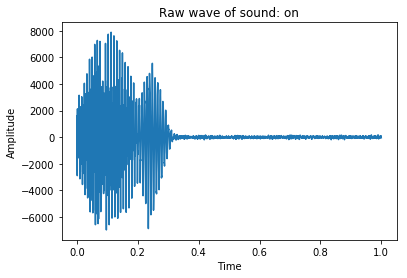

In [27]:
plot_wave(x_train[0], sound_labels[0])

The audio output consists of multiple waves of different frequencies all combined in one. To convert this into a usable format for our classifier we can use a mathematical technique called Fast Fourier transform which effectively converts the combined wave into a spectrum of its underlying frequencies.

However, it is difficult to train our classifier using the full sampled audio wave as it is constantly changing through time. To simplify this we can make the assumption that a signal is statistically stationary in small time windows . So we can frame the signals in  20-40 ms windows and compute the fast Fourier transform over these windows. For frame lengths shorter than 20 ms we don't have enough samples to get a reliable spectral estimate, and for frame lengths longer than 40 ms the signal changes too much throughout the frame.  The number of samples in a 20 ms window of a signal of 16 khz is 16000 * 0.02 = 320. 

To make the transition between windows fluid some overlap of data is used i.e. a section of the data at the end of the last window is used in the next window. A frame step is used to select the intervals between the windows. A frame step of 10 milliseconds produces 160 samples between windows. 

A windowing function is used to get better resolution between the low and high points in the Fourier transform output. Basically, it is a function which you multiply with the data to reduce the impact of the data at the beginning and at the end on of the frame window. 

Taking the Fourier transform of all the windows produces a spectrogram. We can use the log of the spectrogram and use it to directly train our classifier. The log is taken because we don’t hear ‘volume on a linear scale. To increase the perceived volume of a sound requires a proportionally larger increase in energy. For example, doubling the perceived volume can require 8 times more energy (practicalcryptography, n.d.), so energy variations at a large volume sounds need to be quite significant to be perceived by the human ear. 

In [42]:
# the function produces log spectrogram representations of the sound files

def log_specgram(audio, sample_rate, window_size=25,
                 step_size=10, eps=1e-10):
    
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    # get time, frequency and spectogram using signal.spectogram function
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)

    
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


# the function plots the log spectrogram representations of the sound files

def plot_spectogram(audio_sample, sound_name, sample_rate=16000):
    samples = audio_sample
    freqs, times, spectrogram = log_specgram(samples, sample_rate=16000)
    fig, ax = plt.subplots()
    ax.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    
    #set axis ticks
    ax.set_yticks(freqs[::15])
    ax.set_xticks(times[::15])
    ax.set_title('Spectrogram of word: ' + sound_name)
    ax.set_ylabel('Freqs in Hz')
    ax.set_xlabel('Seconds')
    
    plt.show()

In [43]:
sample_rate=16000
spec = log_specgram(x_train[0], sample_rate, window_size=25,
                 step_size=10, eps=1e-10)

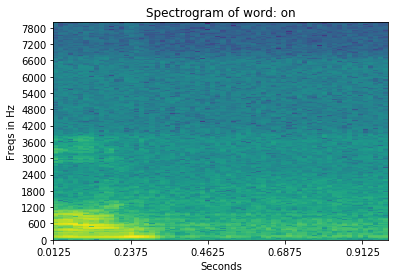

In [44]:
plot_spectogram(x_train[0], sound_labels[0])

There is some further pre-processing which we can do to make the spectrogram further resemble how the human ear measures sounds. The cochlea can’t really distinguish the difference between two relatively similar frequencies. This effect becomes more pronounced as the frequencies increase. So we can bunch the spectrogram into various frequency ranges and calculate the amount of energy which exist in each range. We use triangular filters defined by the Mel scale to bunch these frequencies into 26 filterbanks. This produces 26 vectors of size equivalent to the number of spectrogram coefficient produced by the spectrogram. Each vector is mostly zeros but is non-zero for a certain section of the spectrum corresponding to its filterbank. The filters are not linear and get wider as the frequencies increase. We can then calculate the filterbank energies by multiplying each filterbank with the spectrogram and summing the values. We are now left with 26 numbers which signify the energy at each filterbank. We then take the log of the energies for the same reason given above. Then finally we apply a discrete cosine transform to decorrelate the energies. We can then take the lowest 13 coefficients which gives the Mel Frequency Cepstral Coefficients (MFCC) and these coefficients can be used to train the network. The librosa library has inbuilt functions to calculate this. 

In [51]:
# function to generate mfcc representation of sound file
def _to_mfcc(raw, sample_rate=16000, n_mels=128):
    X = []

    for r in raw:
        S = librosa.feature.melspectrogram(r, sr=sample_rate, n_mels=128)
        # Convert to log scale (dB). We'll use the peak power (max) as reference.
        log_S = librosa.power_to_db(S, ref=np.max)
        mfcc  = librosa.feature.mfcc(S=log_S, n_mfcc=13)

        X += [mfcc]
    
    return np.array(X)

# function to plot mfcc representation of sound file
def plot_mfcc(audio_sample, sound_name, sample_rate=16000, n_mels=128):
    samples = audio_sample
    S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=n_mels)
    log_S = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')

    plt.title('Mel power spectrogram of sound: '+ sound_name)
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

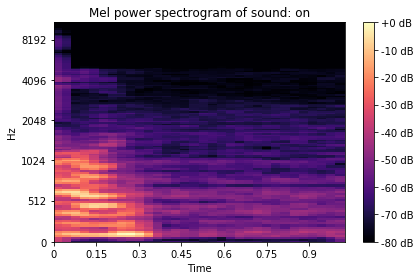

In [52]:
# plot an example of 
plot_mfcc(x_train[0], sound_labels[0])

In [72]:
# import IPython.display as ipd
# ipd.Audio(x_train[0], rate=sample_rate)

In [60]:

x_train_mfcc_trans = _to_mfcc(x_train, sample_rate=16000, n_mels=128)

x_test_mfcc_trans = _to_mfcc(x_test, sample_rate=16000, n_mels=128)

In [63]:
x_test_mfcc_trans.shape

(19417, 13, 32)

In [74]:
x_train_mfcc_trans.shape

(45304, 13, 32)

We will now create an RNN in keras to predict the sound from the mfcc inputs

In [66]:
# create keras lstm model

layers =  [keras.layers.InputLayer(X_t.shape[1:])]
layers += [keras.layers.LSTM(252, return_sequences=1, dropout=0.3)]
layers += [keras.layers.LSTM(252, return_sequences=0, dropout=0.3)]
layers += [keras.layers.Dense(64, activation='relu')]
layers += [keras.layers.Dropout(0.3)]
layers += [keras.layers.Dense(y_train.shape[1], activation='softmax')]
LSTM    = keras.Sequential(layers)     

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [67]:
# summary of model
LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 13, 252)           287280    
_________________________________________________________________
lstm_2 (LSTM)                (None, 252)               509040    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16192     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1950      
Total params: 814,462
Trainable params: 814,462
Non-trainable params: 0
_________________________________________________________________


In [68]:
# compile model
LSTM.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(1e-3), metrics=['acc'])

In [69]:
# fit data to the model
LSTM_hist = LSTM.fit(x_train_mfcc_trans, y_train, validation_data = (x_test_mfcc_trans, y_test), epochs = 150, batch_size=2048, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 45304 samples, validate on 19417 samples
Epoch 1/150
45304/45304 [==============================] - 54s 1ms/step - loss: 3.3885 - acc: 0.0451 - val_loss: 3.3361 - val_acc: 0.0703
Epoch 2/150
45304/45304 [==============================] - 63s 1ms/step - loss: 3.3391 - acc: 0.0649 - val_loss: 3.2169 - val_acc: 0.1043
Epoch 3/150
45304/45304 [==============================] - 58s 1ms/step - loss: 3.2118 - acc: 0.0951 - val_loss: 2.9095 - val_acc: 0.1685
Epoch 4/150
45304/45304 [==============================] - 52s 1ms/step - loss: 3.0002 - acc: 0.1435 - val_loss: 2.6023 - val_acc: 0.2393
Epoch 5/150
45304/45304 [==============================] - 53s 1ms/step - loss: 2.7625 - acc: 0.1996 - val_loss: 2.3331 - val_acc: 0.3186
Epoch 6/150
45304/45304 [==============================] - 53s 1ms/step - loss: 2.5495 - acc: 0.2526 - val_loss: 2.0893 - val_acc: 0.3944
Epoch 7/150
45304/45304 [==============================] - 53s 1ms/step - 

Epoch 58/150
45304/45304 [==============================] - 66s 1ms/step - loss: 0.6137 - acc: 0.8133 - val_loss: 0.6580 - val_acc: 0.8091
Epoch 59/150
45304/45304 [==============================] - 57s 1ms/step - loss: 0.6085 - acc: 0.8148 - val_loss: 0.6411 - val_acc: 0.8122
Epoch 60/150
45304/45304 [==============================] - 55s 1ms/step - loss: 0.5994 - acc: 0.8174 - val_loss: 0.6406 - val_acc: 0.8150
Epoch 61/150
45304/45304 [==============================] - 56s 1ms/step - loss: 0.5899 - acc: 0.8195 - val_loss: 0.6402 - val_acc: 0.8140
Epoch 62/150
45304/45304 [==============================] - 57s 1ms/step - loss: 0.5777 - acc: 0.8228 - val_loss: 0.6331 - val_acc: 0.8169
Epoch 63/150
45304/45304 [==============================] - 59s 1ms/step - loss: 0.5769 - acc: 0.8234 - val_loss: 0.6403 - val_acc: 0.8158
Epoch 64/150
45304/45304 [==============================] - 59s 1ms/step - loss: 0.5788 - acc: 0.8243 - val_loss: 0.6231 - val_acc: 0.8206
Epoch 65/150
45304/45304 [=

Epoch 117/150
45304/45304 [==============================] - 63s 1ms/step - loss: 0.3473 - acc: 0.8910 - val_loss: 0.6549 - val_acc: 0.8295
Epoch 118/150
45304/45304 [==============================] - 66s 1ms/step - loss: 0.3430 - acc: 0.8922 - val_loss: 0.6485 - val_acc: 0.8333
Epoch 119/150
45304/45304 [==============================] - 64s 1ms/step - loss: 0.3374 - acc: 0.8922 - val_loss: 0.6517 - val_acc: 0.8315
Epoch 120/150
45304/45304 [==============================] - 62s 1ms/step - loss: 0.3388 - acc: 0.8923 - val_loss: 0.6433 - val_acc: 0.8343
Epoch 121/150
45304/45304 [==============================] - 63s 1ms/step - loss: 0.3351 - acc: 0.8957 - val_loss: 0.6515 - val_acc: 0.8343
Epoch 122/150
45304/45304 [==============================] - 63s 1ms/step - loss: 0.3394 - acc: 0.8937 - val_loss: 0.6506 - val_acc: 0.8313
Epoch 123/150
45304/45304 [==============================] - 62s 1ms/step - loss: 0.3343 - acc: 0.8949 - val_loss: 0.6645 - val_acc: 0.8320
Epoch 124/150
45304/

Text(0.5, 0, 'epochs')

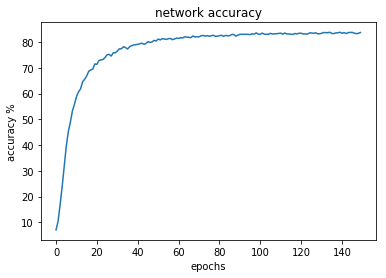

In [87]:
# get test accuracy from history dictionary
testAccRnn = np.array(LSTM_hist.history['val_acc'])

# plot test accuracy
fig = plt.figure()
plt.plot(range(len(testAccRnn)),(testAccRnn*100))
plt.title('network accuracy')
plt.ylabel('accuracy %')
plt.xlabel('epochs')

In [106]:
# check model on random sound in test set
import random
randI = random.randint(0, len(x_test_mfcc_trans))

# predict for random test entry
ypred = LSTM.predict(x_test_mfcc_trans[randI:(randI+1)])

# print prediction
print('predicted sound:',sounds[np.where(ypred[0]==np.max(ypred[0]))[0][0]])
print('actual sound:',sounds[np.where(y_test[randI]==np.max(y_test[randI]))[0][0]])

predicted sound: no
actual sound: no
